<a href="https://colab.research.google.com/github/diluisi/DLBootcampFields/blob/master/Airlines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Airline Tweets Sentiment Analysis

In this short example, we will study the sentiment of a series of 14,485 manually labeled tweets discussing airlines in the US. The original data can be found [here](https://www.kaggle.com/crowdflower/twitter-airline-sentiment).

Let's start by importing the data. I have made the data easily downloadable from Google Drive. We will use the package ```gdown``` to easily obtain our dataset.  ```gdown``` is NOT a Python command, but an operative system command, thus we need to invoke it with the prefix ```!``` which means "run this in the operative system".

The command is

```
gdown Google_Path
```

In [0]:
import gdown
!gdown https://drive.google.com/uc?id=1MuBpWChmJV8thCRTeQpWJRpIGoJwk9gS

Downloading...
From: https://drive.google.com/uc?id=1MuBpWChmJV8thCRTeQpWJRpIGoJwk9gS
To: /content/database.sqlite
5.04MB [00:00, 19.0MB/s]


Note that it downloads it to ```/content/FILENAME```. This is an sqlite dataset, which we can readily import to Pandas as follows.

In [0]:
import sqlite3 as sql
import pandas as pd

conn = sql.connect('/content/database.sqlite')
query = "SELECT * FROM Tweets;"
AirData = pd.read_sql(query, conn)

In [0]:
# We can now see the first few documents.
AirData.iloc[0:3,]

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,567588278875213824,neutral,1.0,,,Delta,,JetBlueNews,,0,@JetBlue's new CEO seeks the right balance to ...,,2015-02-16 23:36:05 -0800,USA,Sydney
1,567590027375702016,negative,1.0,Can't Tell,0.6503,Delta,,nesi_1992,,0,@JetBlue is REALLY getting on my nerves !! 😡😡 ...,,2015-02-16 23:43:02 -0800,undecided,Pacific Time (US & Canada)
2,567591480085463040,negative,1.0,Late Flight,0.346,United,,CPoutloud,,0,@united yes. We waited in line for almost an h...,,2015-02-16 23:48:48 -0800,"Washington, DC",


Of these, the following can be used to predict the target variable ```airline_sentiment```:

- airline: Categorical variable.
- retweet_count: Numerical variable.
- text: Text variable.
- tweet_location: Categorical variable with the location as entered by the user.
- user_timezone: Categorical variable with the location as per the user device.

So, we have multiple categorical variables, one numerical variable and one text variable. Thus, three different data channels can be used to estimate this model. A possible data architecture can be the following:

1. For the categorical variables, generate a categorical embedding which dramatically reduces the number of categories. We will train the embedding such that it considers interactions between categories.
2. For the text variable, use an embedding to generate a text model, and then generate a series of high-level features using a Kim et al. (2005) architecture.
3. Input the numerical variable as another feature for the final dataset.
4. Combine everything with a few dense layers to preprocess the dataset.

We will compare the text-only model with the categorical model in a subset of the data.

## Creating a text-based model

For this we will use the powerful [fastText](https://github.com/facebookresearch/fastText) library by Facebook. There are more modern embeddings available, such as BERT, but they are more time-consuming to use. 

We need to download the fasttext model and apply it to our data, i.e., associate each word with the corresponding embedding vector. fasttext is a heavy program, so it makes sense to use the C++ library directly. This does complicate our life a bit, but nothing a few lines of code can't solve. First, we will download the library and unzip it.

In [0]:
!wget https://github.com/facebookresearch/fastText/archive/v0.9.1.zip
  
!unzip v0.9.1.zip

--2019-09-26 22:17:29--  https://github.com/facebookresearch/fastText/archive/v0.9.1.zip
Resolving github.com (github.com)... 13.229.188.59
Connecting to github.com (github.com)|13.229.188.59|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/facebookresearch/fastText/zip/v0.9.1 [following]
--2019-09-26 22:17:30--  https://codeload.github.com/facebookresearch/fastText/zip/v0.9.1
Resolving codeload.github.com (codeload.github.com)... 13.229.189.0
Connecting to codeload.github.com (codeload.github.com)|13.229.189.0|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘v0.9.1.zip’

v0.9.1.zip              [  <=>               ]   4.13M  13.4MB/s    in 0.3s    

2019-09-26 22:17:30 (13.4 MB/s) - ‘v0.9.1.zip’ saved [4327207]

Archive:  v0.9.1.zip
b5b7d307274ce00ef52198fbc692ed3bd11d9856
   creating: fastText-0.9.1/
   creating: fastText-0.9.1/.circleci/
  inflating: fastText

Now we need to [compile](https://en.wikipedia.org/wiki/Compiler) the library. Compiling turns the code we just downloaded to something the computer can understand. Configuring this is complicated, so programmers add a [makefile](http://www.cs.colby.edu/maxwell/courses/tutorials/maketutor/) with instructions for the compiler. This means we just need to call the command ```make``` in the base folder with the code. This code does it:

In [0]:
%cd fastText-0.9.1

!make

/content/fastText-0.9.1
c++ -pthread -std=c++0x -march=native -O3 -funroll-loops -DNDEBUG -c src/args.cc
c++ -pthread -std=c++0x -march=native -O3 -funroll-loops -DNDEBUG -c src/matrix.cc
c++ -pthread -std=c++0x -march=native -O3 -funroll-loops -DNDEBUG -c src/dictionary.cc
c++ -pthread -std=c++0x -march=native -O3 -funroll-loops -DNDEBUG -c src/loss.cc
c++ -pthread -std=c++0x -march=native -O3 -funroll-loops -DNDEBUG -c src/productquantizer.cc
c++ -pthread -std=c++0x -march=native -O3 -funroll-loops -DNDEBUG -c src/densematrix.cc
c++ -pthread -std=c++0x -march=native -O3 -funroll-loops -DNDEBUG -c src/quantmatrix.cc
c++ -pthread -std=c++0x -march=native -O3 -funroll-loops -DNDEBUG -c src/vector.cc
c++ -pthread -std=c++0x -march=native -O3 -funroll-loops -DNDEBUG -c src/model.cc
c++ -pthread -std=c++0x -march=native -O3 -funroll-loops -DNDEBUG -c src/utils.cc
c++ -pthread -std=c++0x -march=native -O3 -funroll-loops -DNDEBUG -c src/meter.cc
c++ -pthread -std=c++0x -march=native -O3 -fun

There are some warnings, but we can ignore them as they are for future versions.

Now, we need to download the embedding vectors. These are **really heavy downloads** of about 8GB.  fasttext is a language-dependent model, so be sure to download the one for your chosen application. The list is [here](https://fasttext.cc/docs/en/english-vectors.html). There are four levels of embeddings:

- Vectors trained over Wikipedia (1 million words, 16 billion tokens).
- Vectors trained over Wikipedia with subword information.
- Vectors trained over a webcrawl of many websites ([Common Crawl](http://commoncrawl.org/)). This one has 2M words and 200B tokens.
- Vectors trained over a webcrawl of many websites with subword information. 

For the lab we will use the first one, but I encourage you to use try other ones! The download will take a little while.

In [0]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
  
!gunzip -v -f cc.en.300.bin.gz

--2019-09-26 22:17:56--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.20.22.166, 104.20.6.166, 2606:4700:10::6814:6a6, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.20.22.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4503593528 (4.2G) [application/octet-stream]
Saving to: ‘cc.en.300.bin.gz’

cc.en.300.bin.gz    100%[===================>]   4.19G  11.4MB/s    in 6m 21s  

2019-09-26 22:24:18 (11.3 MB/s) - ‘cc.en.300.bin.gz’ saved [4503593528/4503593528]

cc.en.300.bin.gz:	 37.8% -- replaced with cc.en.300.bin


Now we are ready to go!

## Data Preprocessing

Now we'll clean the text, getting rid of special characters and keeping the text in a clear form. Let's first import the packages.

In [0]:
# General imports
import string
import numpy as np
import pandas as pd
import sklearn.feature_extraction as skprep
from sklearn.metrics import roc_curve, auc
from itertools import compress
import matplotlib.pyplot as plt
import seaborn as sns
import random
import codecs
random.seed(20190124)
%matplotlib inline

# Keras imports
import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Input, Embedding, Reshape, merge, MaxPooling1D, Concatenate, concatenate
from keras.layers import Activation
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
from keras.metrics import categorical_crossentropy, categorical_accuracy
from keras.layers.convolutional import *
from keras.preprocessing import image, sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Others
import numpy as np
from sklearn.model_selection import train_test_split

# For AUC estimation and ROC plots
from sklearn.metrics import roc_curve, auc, confusion_matrix

# To visualize models
import matplotlib.pyplot as plt
from keras.utils import plot_model
from IPython.display import Image
%matplotlib inline

In [0]:
# Come back to the original work folder
%cd /content

# Text cleaning
import string

# Collect punctuation signs.
table = str.maketrans(' ', ' ', string.punctuation)

# Remove them from the text
AirData.iloc[:,10] = [j.translate(table) for j in AirData.iloc[:,10]]
AirData.iloc[:,10] = [j.replace('\x96',' ') for j in AirData.iloc[:,10]]

# Eliminate double spaces
AirData.iloc[:,10] = [" ".join(j.split()) for j in AirData.iloc[:,10]]

# Show first 5
AirData.iloc[:, 10].head()

/content


0    JetBlues new CEO seeks the right balance to pl...
1    JetBlue is REALLY getting on my nerves 😡😡 noth...
2    united yes We waited in line for almost an hou...
3    united the we got into the gate at IAH on time...
4    SouthwestAir its cool that my bags take a bit ...
Name: text, dtype: object

## Estimating the embedding

Once we have the embedding model, using it consists of:

1. Calculate the words that appear on the text and save to disk
2. Use the fastText program to obtain the word embeddings.
3. Import the embeddings into a Keras input layer.
4. Train the model!

First, we will start by selecting the individual words. The Keras internal model "[Tokenizer](https://keras.io/preprocessing/text/#tokenizer)" will allow us to quickly do this, with the added benefit of giving us a [dictionary](https://docs.python.org/2/tutorial/datastructures.html#dictionaries) of the words, which will be stored in the "tokenizer" model.

A dictionary is a very powerful object included by Python, which will efficiently index anything by any key. In our case it will index the words and an arbitraty number that will give its position. Read the linked article to know more about dictionaries, but it is important that you understand its usefulness: It allows fast (indexed) access to objects linked by a key (in this case, the words).

In [0]:
tokenizer = Tokenizer() # Creates tokenizer model.
tokenizer.fit_on_texts(AirData.iloc[:, 10]) # Trains it over the tokens that we have.

# Get words
Vals = list(tokenizer.word_index.keys())

# Write CSV with the output.
file = codecs.open('AirlineWords.csv', "w", "utf-8")

for item in Vals:
    file.write("%s\r\n" % item)
    
file.close()
!ls

AirlineWords.csv  database.sqlite  fastText-0.9.1  sample_data	v0.9.1.zip


In [0]:
!head AirlineWords.csv

to
the
i
a
united
you
for
flight
on
and


Let's get the embeddings! We need to call the fasttext software from the command line.

In [0]:
!./fastText-0.9.1/fasttext print-sentence-vectors fastText-0.9.1/cc.en.300.bin < AirlineWords.csv > EmbeddingAirline.tsv

tcmalloc: large alloc 4800004096 bytes == 0x55d6e762a000 @  0x7f3c59d52887 0x55d6d3b308cf 0x55d6d3b3b3e4 0x55d6d3b3bed1 0x55d6d3b47873 0x55d6d3b12ef8 0x7f3c58defb97 0x55d6d3b12f8a
tcmalloc: large alloc 2400002048 bytes == 0x55d8057ce000 @  0x7f3c59d52887 0x55d6d3b308cf 0x55d6d3b3b428 0x55d6d3b3bed1 0x55d6d3b47873 0x55d6d3b12ef8 0x7f3c58defb97 0x55d6d3b12f8a


As always, ignore the warnings. They are basically saying "I need a very large amount of RAM to do what you are asking!".

This process actually takes a relatively long time. Let's take a look at the command part by part:

- ```!./fastText-0.9.1/fasttext``` invokes fasttext. The notation "./" means "execute this program".

- We give it two parameters ```print-sentence-vectors``` which instruct fastText to actually give us the embedding for every word, and ```fastText-0.9.1/cc.en.300.bin``` which is the language model we are using.

- Then comes the processing of the inputs and outputs. The "```< AirlineWords.csv```" is telling Linux "give AirlineWords.csv as an input to what's to the left" and the "```> EmbeddingAirline.tsv```" is telling Linux "write whatever is outputted from the left into EmbeddingIMDB.tsv".

The output is a space-separated file with the embedding vectors in the same order we gave them to the software.

In [0]:
!head EmbeddingAirline.tsv

0.0015377 0.0092387 -0.0097338 -0.0035523 -0.020367 -0.017491 -0.032187 0.031876 -0.028371 -0.013964 0.0089369 -0.012344 -0.014067 0.012274 -0.0013164 -0.011613 0.0021162 0.0059631 -0.019175 0.21828 0.021152 0.023211 -0.0132 -0.035278 -0.074999 -0.026028 0.00082388 -0.0030167 -0.068258 0.063533 -0.0098843 -0.041354 0.014589 0.023406 0.014214 -0.013643 -0.20485 0.12002 -0.0040268 -0.01391 0.014301 0.016497 -0.042776 0.021333 0.087691 0.039735 0.011358 0.060788 0.0171 0.0093087 0.025502 -0.033427 -0.018634 -0.023903 -0.0083371 -0.02316 -0.042465 0.04977 -0.038526 -0.045227 -0.0066938 -0.0071283 0.0023063 -0.19473 -0.019533 -0.021869 0.010451 -0.028849 -0.005502 -0.015123 0.022984 0.0069817 0.032349 -0.0067217 0.0027925 -0.030843 0.025418 0.039041 -0.035046 -0.06629 0.0094512 -0.013102 -0.0071913 -0.0043986 0.135 -0.0076825 0.033408 0.094652 -0.014759 -0.11064 -0.010345 -0.026574 0.030875 -0.017007 -0.015609 -0.16973 -0.065682 0.0074308 -0.026655 -0.014358 -0.0026736 0.036283 0.016993 -0.

Note that this is only for training, for testing we would:

- If we kept the embedding as is, we simply calculate the new embeddings for the new words and add it to our matrix.

- If we retrained the embeddings, then we would either use the output that we already have if the word was in our original vocabulary, or just leave a vector of zeros for those words if it is not.

fastText outputs space-separated words. We replace them with a comma.

In [0]:
import fileinput

with fileinput.FileInput('EmbeddingAirline.tsv', inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace(' ', ','), end='')

We add a first line with the variable names, to be able to import it back.

In [0]:
# Create the first line
firstLine = ','.join(['D'+str(i) for i in np.arange(1, 301)]) + '\n'

# Open as read only. Read the file
with open('EmbeddingAirline.tsv', 'r') as original: 
  data = original.read()

# Open to write and write the first line and the rest
with open('EmbeddingAirline.csv', 'w') as modified: 
  modified.write(firstLine + data)

In [0]:
!head EmbeddingAirline.csv

D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,D16,D17,D18,D19,D20,D21,D22,D23,D24,D25,D26,D27,D28,D29,D30,D31,D32,D33,D34,D35,D36,D37,D38,D39,D40,D41,D42,D43,D44,D45,D46,D47,D48,D49,D50,D51,D52,D53,D54,D55,D56,D57,D58,D59,D60,D61,D62,D63,D64,D65,D66,D67,D68,D69,D70,D71,D72,D73,D74,D75,D76,D77,D78,D79,D80,D81,D82,D83,D84,D85,D86,D87,D88,D89,D90,D91,D92,D93,D94,D95,D96,D97,D98,D99,D100,D101,D102,D103,D104,D105,D106,D107,D108,D109,D110,D111,D112,D113,D114,D115,D116,D117,D118,D119,D120,D121,D122,D123,D124,D125,D126,D127,D128,D129,D130,D131,D132,D133,D134,D135,D136,D137,D138,D139,D140,D141,D142,D143,D144,D145,D146,D147,D148,D149,D150,D151,D152,D153,D154,D155,D156,D157,D158,D159,D160,D161,D162,D163,D164,D165,D166,D167,D168,D169,D170,D171,D172,D173,D174,D175,D176,D177,D178,D179,D180,D181,D182,D183,D184,D185,D186,D187,D188,D189,D190,D191,D192,D193,D194,D195,D196,D197,D198,D199,D200,D201,D202,D203,D204,D205,D206,D207,D208,D209,D210,D211,D212,D213,D214,D215,D216,D217,D218,D219,D220,D221,D22

Just what we wanted! Now we have a matrix with every word in the document with its corresponding Embedding. We can now import this file into Python, and use it to train our model.

## Creating a text embedding

The next step is to actually train a neural network with an Embedding Layer. For this, Keras has the aptly named "Embedding" layer, which will take care of our structures. The following code creates a very simple network that does the following:

1. Read the embeddings.
2. Calculate the One-Hot inputs (by using an "index") which will index which words are in which text.
3. Create a layer that associates the indexes with the embeddings.
4. Create the rest of the architecture.
5. Train the model.

In [0]:
# Read word embeddings
Embeddings = pd.read_csv('EmbeddingAirline.csv', sep=',', decimal = '.', 
                         low_memory = True, index_col = False)
Embeddings.describe()

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,D16,D17,D18,D19,D20,D21,D22,D23,D24,D25,D26,D27,D28,D29,D30,D31,D32,D33,D34,D35,D36,D37,D38,D39,D40,...,D261,D262,D263,D264,D265,D266,D267,D268,D269,D270,D271,D272,D273,D274,D275,D276,D277,D278,D279,D280,D281,D282,D283,D284,D285,D286,D287,D288,D289,D290,D291,D292,D293,D294,D295,D296,D297,D298,D299,D300
count,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,...,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000
mean,-0.006258,-0.000873,-0.003477,0.057365,-0.016376,-0.012075,-0.000632,-0.008663,-0.000485,0.003750,0.000497,-0.006945,0.008211,-0.002777,-0.006340,-0.029547,0.012450,0.003609,-0.005848,0.017865,-0.013562,-0.000002,0.003481,-0.001433,0.018932,-0.000074,-0.009023,0.008864,0.001714,0.072051,-0.006343,-0.004358,-0.003585,0.009561,0.011021,0.003957,0.001137,0.034446,-0.004930,0.011645,...,0.000518,-0.004070,-0.051429,0.000817,-0.023872,-0.009874,-0.000408,-0.008903,0.004303,0.027282,-0.008996,0.003845,-0.031803,-0.015657,0.009575,-0.002249,-0.017719,-0.004260,-0.025546,0.005288,-0.004237,-0.014362,-0.043295,0.006639,-0.006159,-0.002606,0.001053,-0.045420,0.001725,-0.017173,0.023314,0.003798,-0.055232,0.010030,0.001968,0.003536,0.004578,0.068337,0.000540,-0.004950
std,0.051391,0.051848,0.054377,0.068417,0.060408,0.059002,0.057892,0.051771,0.049445,0.052389,0.055651,0.052156,0.051948,0.049493,0.053214,0.071832,0.060934,0.049566,0.053500,0.056364,0.051337,0.052438,0.051230,0.052501,0.061928,0.055739,0.053026,0.053349,0.049708,0.084296,0.051969,0.049006,0.049613,0.065603,0.050797,0.050935,0.059459,0.066680,0.049401,0.051981,...,0.052489,0.058994,0.095967,0.051548,0.054638,0.052117,0.054191,0.049467,0.055136,0.074280,0.053371,0.057065,0.061152,0.053261,0.052384,0.050611,0.059783,0.064032,0.055888,0.055196,0.050841,0.054295,0.054404,0.053418,0.052098,0.054055,0.051014,0.075028,0.055729,0.053177,0.065024,0.051070,0.073290,0.055045,0.052004,0.050797,0.051523,0.070596,0.055468,0.053590
min,-0.222520,-0.258440,-0.239990,-0.194620,-0.300660,-0.248440,-0.242400,-0.252270,-0.253600,-0.212850,-0.248430,-0.237560,-0.218810,-0.196500,-0.236690,-0.360120,-0.220610,-0.210030,-0.269360,-0.227190,-0.263310,-0.227430,-0.227680,-0.206130,-0.227410,-0.231870,-0.204340,-0.187510,-0.206980,-0.315130,-0.224930,-0.208040,-0.218730,-0.340690,-0.223820,-0.198020,-0.244160,-0.211640,-0.218390,-0.229720,...,-0.232400,-0.285110,-0.403330,-0.211560,-0.331080,-0.249380,-0.188610,-0.209840,-0.278300,-0.269830,-0.220600,-0.239500,-0.305090,-0.293180,-0.197310,-0.223930,-0.256460,-0.259480,-0.323180,-0.253920,-0.244270,-0.257990,-0.320150,-0.274150,-0.273080,-0.279630,-0.199220,-0.321610,-0.210150,-0.215750,-0.252000,-0.211450,-0.369170,-0.216090,-0.178420,-0.224390,-0.200500,-0.162450,-0.213720,-0.215610
25%,-0.041199,-0.034483,-0.038635,0.017463,-0.055398,-0.052892,-0.037075,-0.041917,-0.032821,-0.030287,-0.036507,-0.038688,-0.024077,-0.034422,-0.042598,-0.070622,-0.029081,-0.029073,-0.040195,-0.017654,-0.048049,-0.033994,-0.029812,-0.036559,-0.020054,-0.038688,-0.045370,-0.025714,-0

We will now create a dictionary for the embeddings. The zip function allows to create the (key, element) structure that we need. Read more about the zip function [here](https://docs.python.org/3.7/library/functions.html#zip). 

In [0]:
# Create embedding dictionary

EmbeddingsDict = dict(zip(Vals, Embeddings.values))

Now, let's study our texts to create the optimal embedding layer. One of the decisions we need to make is what is going to be the maximum size of our documents. Too large, and we will need to add a lot of padding thus will make it inefficient; too small, and we will be losing a lot of information. There is no clear rule here, I usually try to cover 90% of all elements, but you can argue anything that makes sense to you.

Avg. no of words: 17.53
Std. deviation: 6.86
Max words: 36


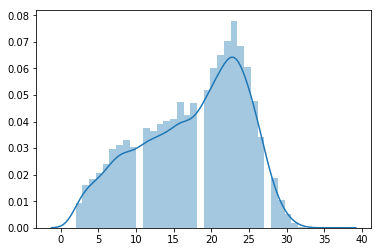

In [0]:
# Count maximum number of words per file.
wordDist = [len(w.split()) for w in AirData.iloc[:, 10]]
print('Avg. no of words: ' + str(np.round(np.mean(wordDist), 2)))
print('Std. deviation: ' + str(np.round(np.std(wordDist), 2)))
print('Max words: ' + str(np.max(wordDist)))

# Generate the plot
distAirlines = sns.distplot(wordDist)

# I'm saving the image to a PDF, as it makes it easier later to download.
distAirlines.figure.savefig("wordDist.pdf", format = "pdf")

Arbitrarily, we will use 36 words, as it will cover all texts. Try different values!

Now we create the input layer. The first layer will have the index of each word per-text, which then we will use to efficiently associate with the embedding. For this, we use Keras' "pad_sequence". This will either add padding to texts that are smaller than 36, or trim the ones that are longer.


In [0]:
# Create word index from input
sequences = tokenizer.texts_to_sequences(AirData.iloc[:, 10]) # Create the sequences.

# Creates the indexes. Word index is a dictionary with words in it.
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# Creates the training dataset, adding padding when necessary.
data = pad_sequences(sequences, maxlen=36, 
                     padding = 'post') # add padding at the end. No difference in practice.

# Creates the objective function
labels = pd.get_dummies(AirData['airline_sentiment'])
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 17132 unique tokens.
Shape of data tensor: (14485, 36)
Shape of label tensor: (14485, 3)


In [0]:
data[0]

array([ 851,  146,  617, 2219,    2,  185, 1782,    1,   75,  206,   10,
        805, 6565, 1248, 6566, 6567,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0], dtype=int32)

As we can see above, our data now is a matrix corresponding to where on the embedding matrix is the vector we are looking for. This is an extremely efficient way of storing embeddings, but uses more CPU. That's ok though!

Now we are almost ready! Now we need to construct the Embedding matrix. This matrix will have the weights associated with each index. Keras will automatically construct the correct embedding of length 36 (see below)

In [0]:
# Create first matrix full with 0's
embedding_matrix = np.zeros((len(word_index) + 1, 300))

# Generate embeddings matrix
for word, i in word_index.items():
    embedding_vector = EmbeddingsDict.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# Print what came out
embedding_matrix

array([[ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  0.0000e+00,
         0.0000e+00,  0.0000e+00],
       [ 1.5377e-03,  9.2387e-03, -9.7338e-03, ...,  1.0695e-01,
        -1.6719e-02,  2.3490e-03],
       [-4.0902e-02,  5.8467e-02, -1.0321e-02, ...,  1.8736e-01,
         3.5375e-04, -3.3145e-03],
       ...,
       [-3.4614e-02, -8.0132e-02,  5.4029e-02, ...,  2.8919e-03,
         3.6898e-02, -1.4643e-04],
       [-5.8192e-03, -3.5542e-02,  8.6070e-03, ...,  3.2873e-02,
         1.2412e-03, -3.8054e-02],
       [-4.8964e-02, -1.8465e-02, -2.3328e-02, ...,  1.0124e-01,
         3.2597e-02,  4.4780e-03]])

## Training the model

As we saw in the lectures, Google's LeNet showed that stacking parallel layers of convolution (so, not sequential models) seemed like a good idea. This was exploited by [Kim et al. (2015)](https://arxiv.org/abs/1408.5882) to create an architecture that uses multiple filters of different lengths, before a final dense layer.

The plot of this architecture follows.

![](https://drive.google.com/uc?export=view&id=1W41RmVNWLPHSSm0gR9yEzVPBpyZJ3ym7)

Having parallel layers is the opossite of having a sequential model, so we need to use the excellent [Model API](https://keras.io/models/model/) of Keras, which will allow us to get as creating as we want with our models.

Our architecture now is as follows:

1. An embedding layer, just like before.
2. A parallel model of four layers, each consisting of:
    - A Conv1D layer with kernel sizes [2, 3, 4, 6] (arbitrary, play around with this), with 128 filters (also arbitrary).
    - A max pooling layer of size Embedding Dimension - Filter Size + 1. Basically get just the best feature per filter.
    - A flattening layer to turn this into a vector.
3. A dense layer of size 128.
4. Dropout with probability 0.5.
5. An output layer of size 1.

The authors discuss that this model will have a much better capacity to study complex structures without overfitting.

So, let's start by creating the stacked structure. Given that these go in parallel, we need to create the structure Conv1D - MaxPool - Flattening, and then append them into an object. Finally, the special [Concatenate](https://keras.io/layers/merge/#concatenate) layer is the one that puts them in parallel next to each other. We will also use this one when we are playing around with our categorical embeddings.

The following codes does this at once for all filter sizes.

In [0]:
# Filter sizes to use.
filter_sizes = (2,3,4,6)

# Initialize. We need to give it the input dimension (from the Embedding!)
graph_in = Input(shape=(36, 300))
convs = []
avgs = []

# This for stacks the layers. Inside each for, we build the sequence of layer. The command "append" adds
# that to the "conv" variable, which is simply a stack of convolutions.
for fsz in filter_sizes:
    conv = Conv1D(filters=128,
                  kernel_size=fsz,
                         padding='valid',
                         activation='relu',
                         strides=1)(graph_in) # Note the (graph_in). This means "put this layer AFTER the graph_in layer.
    conv = Dropout(0.6)(conv)
    pool = MaxPooling1D(pool_size=36 - fsz + 1)(conv) # Put this layer AFTER the convolution just created.
    flattenMax = Flatten()(pool) # Flatten the pooling layer.
    convs.append(flattenMax) # Append this to the convs object that saves the stack.
    
# Concatenate layers.
if len(filter_sizes)>1:
    out = Concatenate()(convs)
else:
    out = convs[0]

graph = Model(inputs=graph_in, outputs=out, name="graphModel")

graph.summary()

Model: "graphModel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 36, 300)      0                                            
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 35, 128)      76928       input_11[0][0]                   
__________________________________________________________________________________________________
conv1d_19 (Conv1D)              (None, 34, 128)      115328      input_11[0][0]                   
__________________________________________________________________________________________________
conv1d_20 (Conv1D)              (None, 33, 128)      153728      input_11[0][0]                   
_________________________________________________________________________________________

We can also plot our structure, much more useful to visualize complex networks.

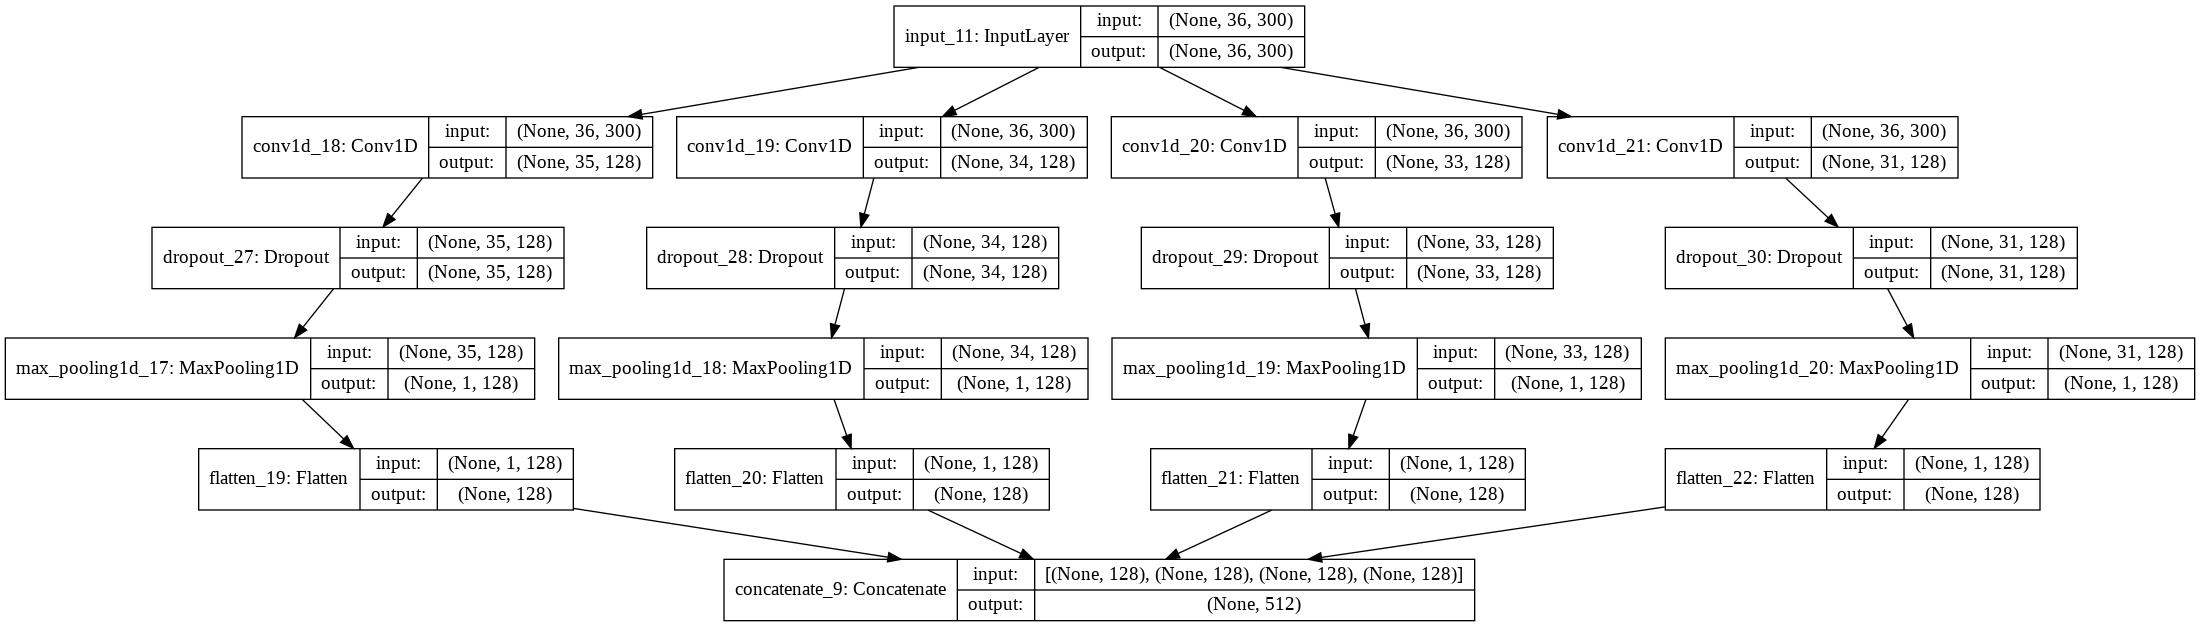

In [0]:
import matplotlib.pyplot as plt
from keras.utils import plot_model
from IPython.display import Image
%matplotlib inline

plot_model(graph, show_shapes=True, show_layer_names=True, to_file='GraphModel.png')
Image(retina=True, filename='GraphModel.png')

Note that we named the model "graphModel", and that it follows the architecture we discussed. This is just the "middle" part of the network, so we need to add an input layer, and an output layer.

We can do this with a traditional sequential model.

In [0]:
# Final model
model = Sequential()
embedding_layer = Embedding(len(embedding_matrix),           # Words in the embedding.
                            300,                           # Embedding dimension
                            weights=[embedding_matrix],    # The weights we just calculated
                            input_length=36,              # The maximum number of words.
                            trainable=False)               # To NOT recalculate weights!

model.add(embedding_layer)

# Now we add our graph model
model.add(graph)

# Add a few layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(3, activation='sigmoid'))

In [0]:
# adam = Adam(clipnorm=.1)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [0]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 36, 300)           5139900   
_________________________________________________________________
graphModel (Model)           (None, 512)               576512    
_________________________________________________________________
dense_17 (Dense)             (None, 128)               65664     
_________________________________________________________________
dropout_31 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 3)                 387       
Total params: 5,782,463
Trainable params: 642,563
Non-trainable params: 5,139,900
_________________________________________________________________


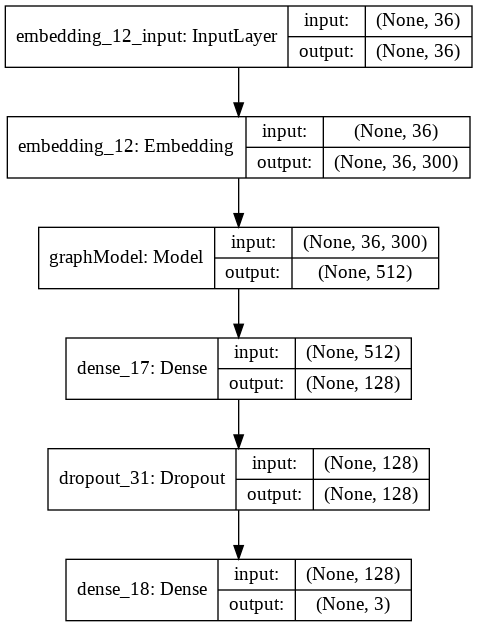

In [0]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image(retina=True, filename='model.png')

The summary shows what we expected: The graph model is thought to be just one more layer of our main sequential model. This allow us to train very complex models! An example would be Google's LeNet (see example [here](https://colab.research.google.com/drive/1CVm50PGE4vhtB5I_a_yc4h5F-itKOVL9)). The goal is simply to build the basic building blocks independently and stack those.

Let's train our model. Now we can simply train our neural network, splitting into train and test datasets.

In [0]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.33,
                                                    random_state=20190925, 
                                                    stratify = labels)

# Define Class weights for balance
class_weight = {0: 14485 / (3 * 9082),
                1: 14485 / (3 * 3069),
                2: 14485 / (3 * 2334)}

In [0]:
# Fit the model
model.fit(X_train, y_train, validation_split=0.33, epochs=5, batch_size=20,
          class_weight = class_weight)

Train on 6501 samples, validate on 3203 samples
Epoch 1/5
6501/6501 [==============================] - 6s 964us/step - loss: 0.8708 - acc: 0.6196 - val_loss: 0.7109 - val_acc: 0.7687
Epoch 2/5
6501/6501 [==============================] - 5s 803us/step - loss: 0.6351 - acc: 0.7565 - val_loss: 0.6393 - val_acc: 0.7640
Epoch 3/5
6501/6501 [==============================] - 5s 802us/step - loss: 0.5607 - acc: 0.7805 - val_loss: 0.6102 - val_acc: 0.8046
Epoch 4/5
6501/6501 [==============================] - 5s 758us/step - loss: 0.4798 - acc: 0.8196 - val_loss: 0.5798 - val_acc: 0.8002
Epoch 5/5
6501/6501 [==============================] - 5s 760us/step - loss: 0.4115 - acc: 0.8423 - val_loss: 0.5779 - val_acc: 0.8083


Let's check the convergence plots.

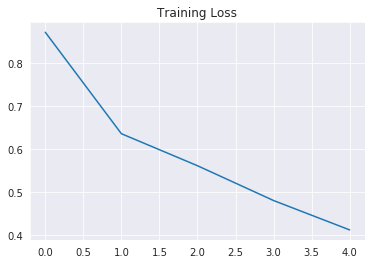

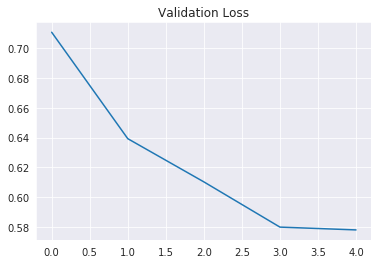

In [0]:
# Plot history
sns.set_style("darkgrid")
plt.plot(model.history.history['loss'])
plt.title('Training Loss')

plt.show()

sns.set_style("darkgrid")
plt.plot(model.history.history['val_loss'])
plt.title('Validation Loss')

plt.show()

Let's train until we are happy with the model :). We are already getting impressive results! This is the power of a well trained neural network.

Let's apply this model to the test set to see the test accuracy.


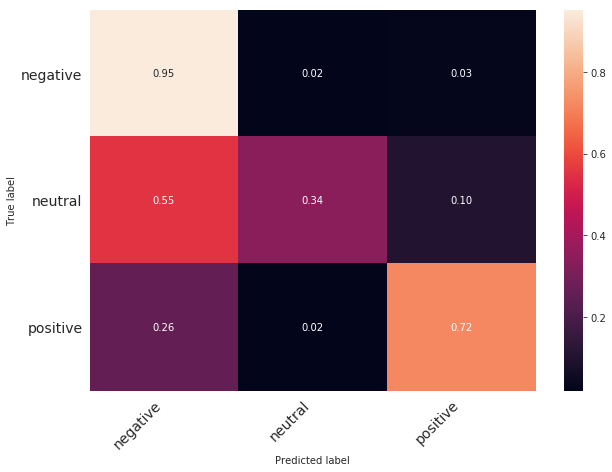

In [0]:
# Calculate outputs in test set
prob_test = np.round(model.predict(X_test))
prob_test = pd.DataFrame(data = prob_test, columns = ['negative', 'neutral', 'positive'])
prob_test = prob_test.idxmax(axis = 1)

y_test_label = y_test.idxmax(axis = 1)

# Calculate confusion matrix
confusion_matrix_dnn = confusion_matrix(y_true = y_test_label, 
                    y_pred = prob_test)

# Turn matrix to percentages
confusion_matrix_dnn = confusion_matrix_dnn.astype('float') / confusion_matrix_dnn.sum(axis=1)[:, np.newaxis]

# Turn to dataframe
df_cm = pd.DataFrame(
        confusion_matrix_dnn, index=['negative', 'neutral', 'positive'],
         columns=['negative', 'neutral', 'positive'], 
)

# Parameters of the image
figsize = (10,7)
fontsize=14

# Create image
fig = plt.figure(figsize=figsize)
heatmap = sns.heatmap(df_cm, annot=True, fmt='.2f')

# Make it nicer
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, 
                             ha='right', fontsize=fontsize)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45,
                             ha='right', fontsize=fontsize)

# Add labels
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Plot!
plt.show()

## Multimodal learning

Let's now add multiple inputs and outputs. This is really easy to do with Keras' functional API. First, we define the categorical embedding.

In [0]:
# Create dummies from the categorical variables
Dummies = AirData.iloc[:, np.r_[5, 14]]
print('There are %i airlines' % Dummies.airline.unique().shape)
print('There are %i timezones' % Dummies.user_timezone.unique().shape)

# Encode them as numeric
from sklearn import preprocessing

le_airlines = preprocessing.LabelEncoder()
le_airlines.fit(Dummies.iloc[:, 0])
Dummies['airline'] = le_airlines.transform(Dummies.iloc[:, 0])

le_timezones = preprocessing.LabelEncoder()
le_timezones.fit(Dummies.iloc[:, 1])
Dummies['user_timezone'] = le_timezones.transform(Dummies.iloc[:, 1])

Dummies.describe()

There are 6 airlines
There are 86 timezones


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,airline,user_timezone
count,14485.000000,14485.000000
mean,2.320262,25.329237
std,1.529632,22.910909
min,0.000000,0.000000
25%,1.000000,0.000000
50%,2.000000,28.000000
75%,4.000000,32.000000
max,5.000000,85.000000


We have 92 dummy columns which we would like to turn into an embedding. The process is the same as the embedding before, we just create a model with those inputs and outputs using the model  API.

In [0]:
# Generate the input
Input_cat = Input(shape=(2, ))

# Generate the embedding
embedding_layer_cat = Embedding(input_dim = 92 + 1,        # Input size
                                output_dim = 30,           # Embedding dimensions
                                input_length=2,            # Variables.
                                trainable=True)(Input_cat) # Allow weight training.

# Flatten the embedding to make it a proper layer.
embedding_layer_cat = Flatten()(embedding_layer_cat)

We use 30 dimensions for the embedding. This is a free parameter that we must determine. Experimentally, this number should be between $[\sqrt{I}, I/2]$, where $I$ is the number of dummy variables in the input.

We now just need the numerical model to add the lonely numerical variable.

In [0]:
num_in = Input(shape=(1,), name='numerical_input')

We now re-create our text model, but without the dense layers.

In [0]:
# Filter sizes to use.
filter_sizes = (2,3,4,6)

# Initialize. We need to give it the input dimension (from the Embedding!)
graph_in = Input(shape=(36, ))
embedding_layer = Embedding(len(embedding_matrix),           # Words in the embedding.
                            300,                           # Embedding dimension
                            weights=[embedding_matrix],    # The weights we just calculated
                            input_length=36,              # The maximum number of words.
                            trainable=False)(graph_in)               # To NOT recalculate weights!
convs = []
avgs = []

# This for stacks the layers. Inside each for, we build the sequence of layer. The command "append" adds
# that to the "conv" variable, which is simply a stack of convolutions.
for fsz in filter_sizes:
    conv = Conv1D(filters=128,
                  kernel_size=fsz,
                         padding='valid',
                         activation='relu',
                         strides=1)(embedding_layer) # Note the (embedding_layer). This means "put this layer AFTER the graph_in layer.
    conv = Dropout(0.6)(conv)
    pool = MaxPooling1D(pool_size=36 - fsz + 1)(conv) # Put this layer AFTER the convolution just created.
    flattenMax = Flatten()(pool) # Flatten the pooling layer.
    convs.append(flattenMax) # Append this to the convs object that saves the stack.
    
# Concatenate layers.
if len(filter_sizes)>1:
    out = Concatenate()(convs)
else:
    out = convs[0]

graph = Model(inputs=graph_in, outputs=out, name="graphModel")

graph.summary()



Model: "graphModel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 36)           0                                            
__________________________________________________________________________________________________
embedding_15 (Embedding)        (None, 36, 300)      5139900     input_15[0][0]                   
__________________________________________________________________________________________________
conv1d_29 (Conv1D)              (None, 35, 128)      76928       embedding_15[0][0]               
__________________________________________________________________________________________________
conv1d_30 (Conv1D)              (None, 34, 128)      115328      embedding_15[0][0]               
_________________________________________________________________________________________

We are ready to start designing the model! We will now use the functional API to merge all of these models using a Concatenate layer.

In [0]:
x = concatenate([num_in, embedding_layer_cat, out])

And finally we add a few dense layers with Dropout

In [0]:
# Dense layers
x = Dense(128, activation= 'relu')(x)
x = Dropout(0.4)(x)
x = Dense(128, activation= 'relu')(x)
x = Dropout(0.4)(x)

# Output layer
out_combined = Dense(3, activation = 'softmax')(x)

And to finish we create and inspect the combined model.

In [0]:
Multi_Model = Model(inputs = [graph_in, num_in, Input_cat], outputs = out_combined)

# adam = Adam(clipnorm=.1)
Multi_Model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

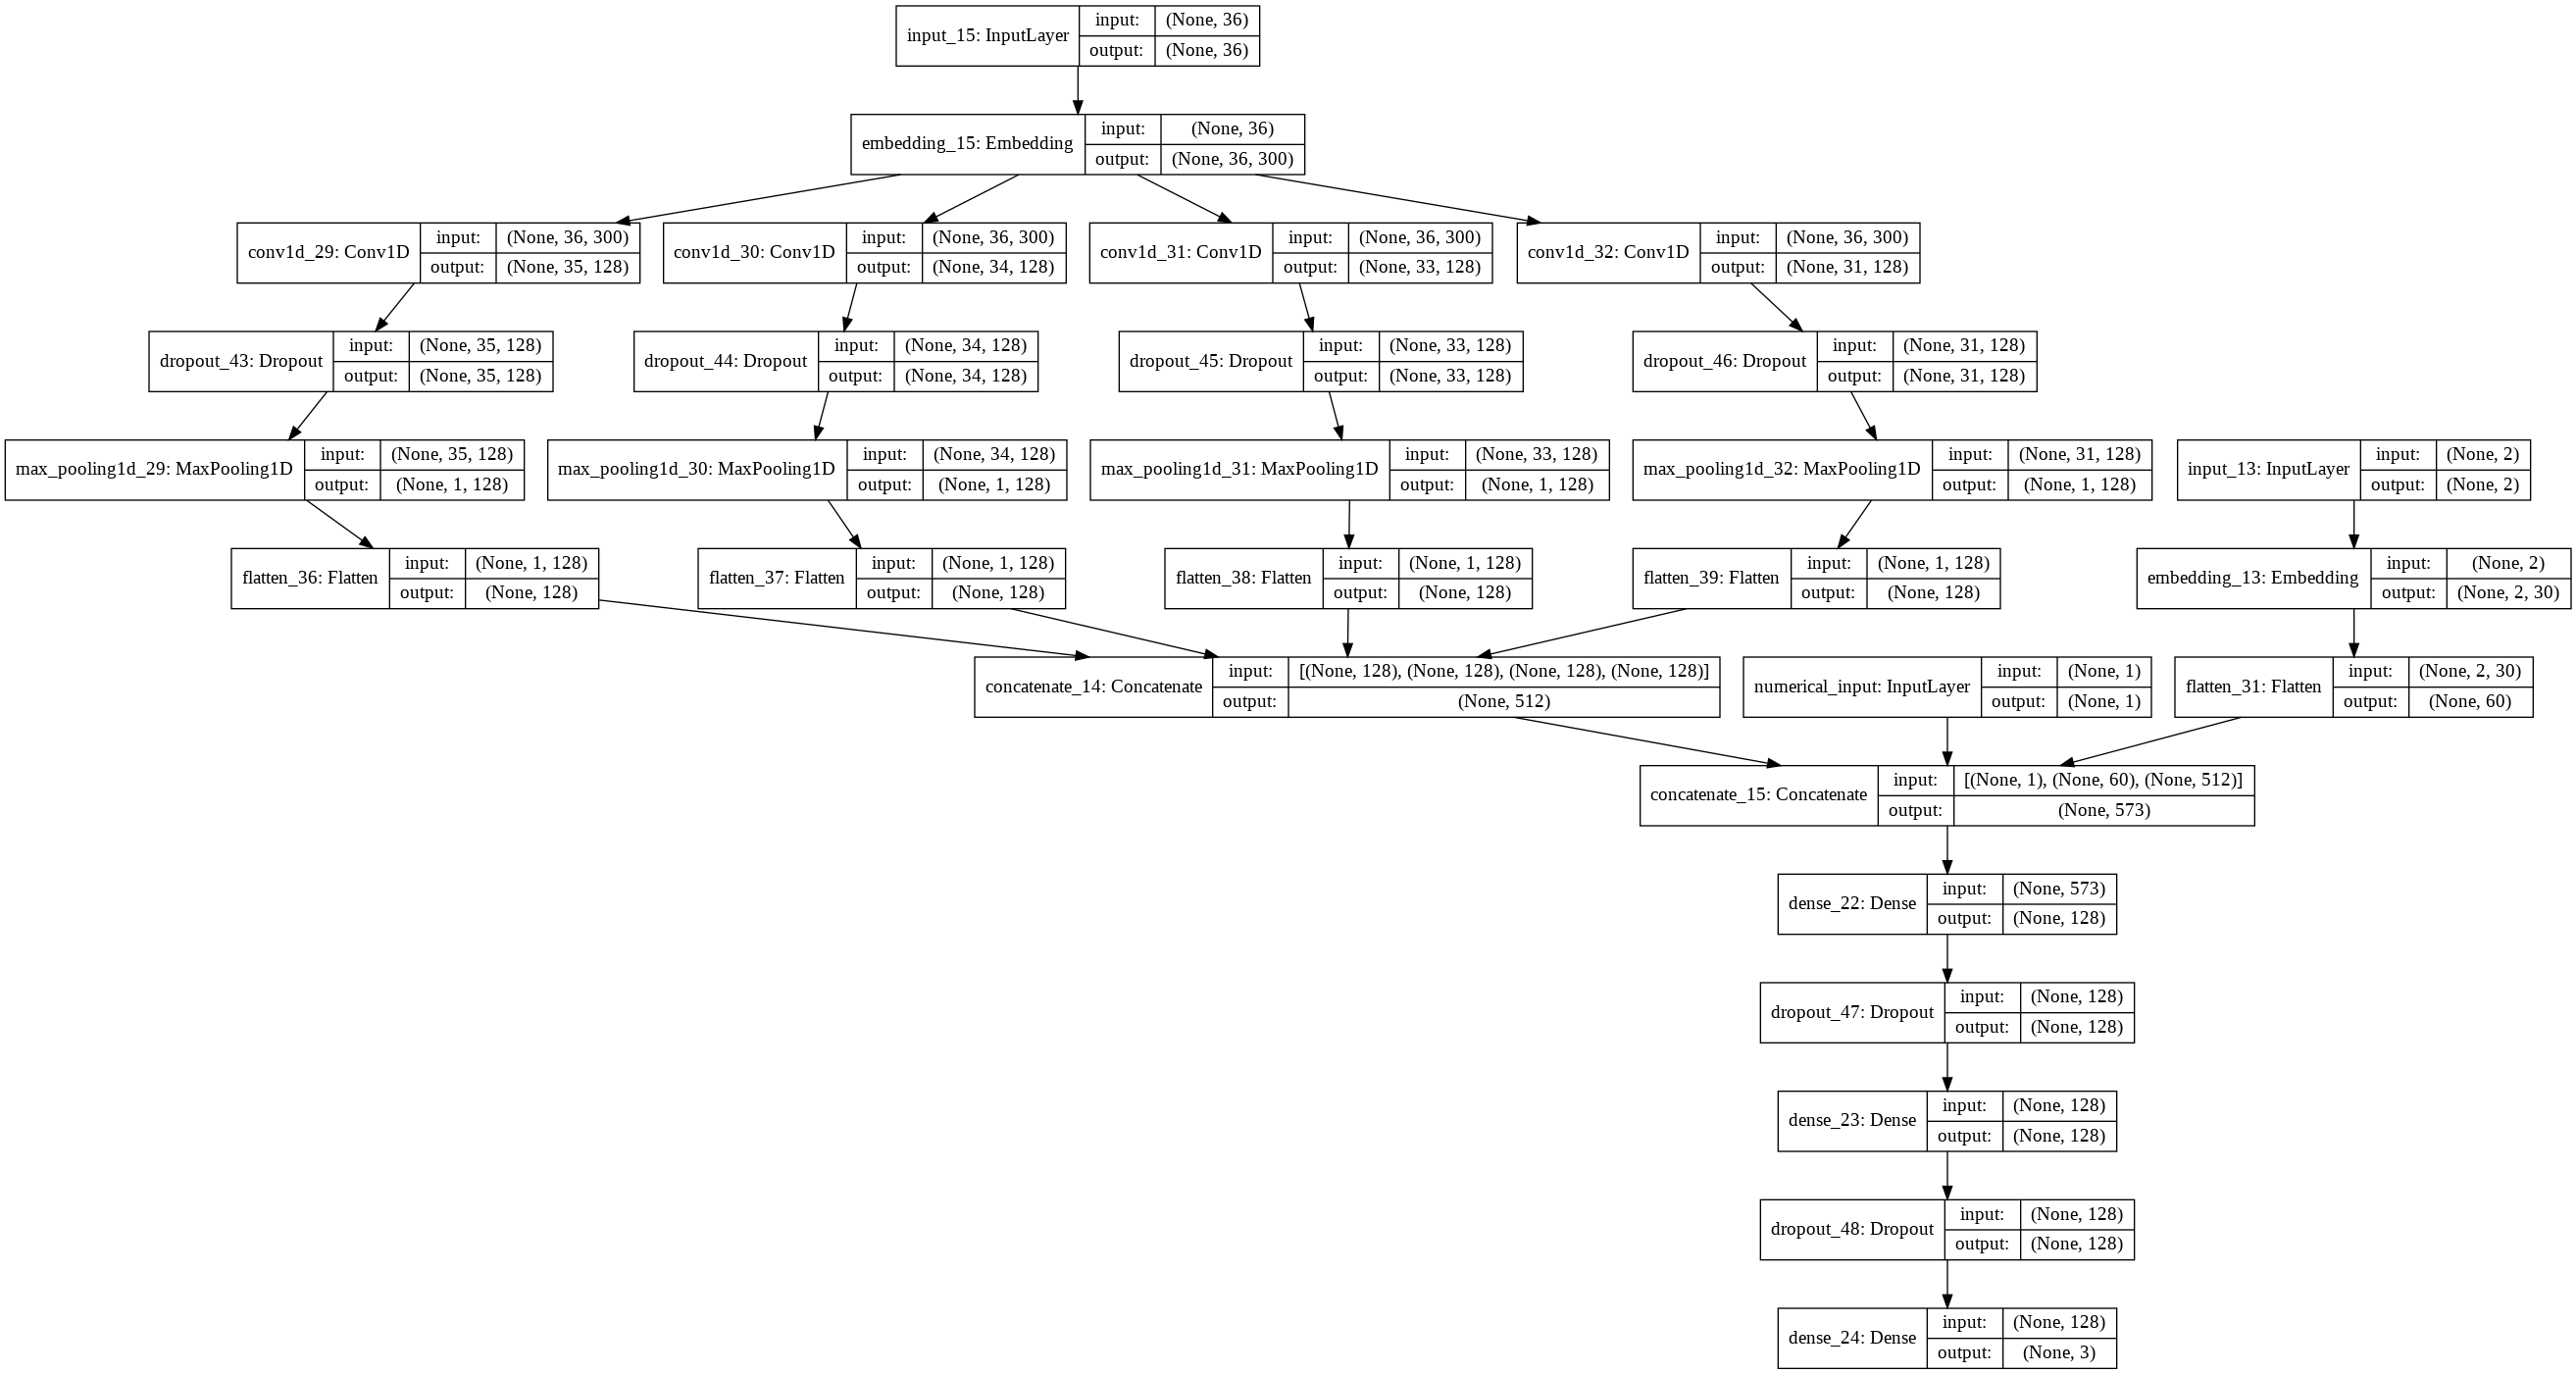

In [0]:
plot_model(Multi_Model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image(retina=True, filename='model.png')

In [0]:
Multi_Model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 36)           0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 36, 300)      5139900     input_12[0][0]                   
__________________________________________________________________________________________________
conv1d_21 (Conv1D)              (None, 35, 128)      76928       embedding_12[0][0]               
__________________________________________________________________________________________________
conv1d_22 (Conv1D)              (None, 34, 128)      115328      embedding_12[0][0]               
____________________________________________________________________________________________

And now we train! To train the model we need to provide the inputs in the order they were specified in the model definition. We will also create a train and test set for these dataset.

In [0]:
multi_data = np.concatenate((np.expand_dims(AirData['retweet_count'], axis = 1),
                       Dummies, data), axis = 1)

X_train, X_test, y_train, y_test = train_test_split(multi_data, labels, test_size=0.33,
                                                    random_state=20190925, 
                                                    stratify = labels)

# 0: Numerical, 1:3 -> Dummies, 3:39 -> Categorical

In [0]:
# Define Class weights for balance
class_weight = {0: 14485 / (3 * 9082),
                1: 14485 / (2 * 3069),
                2: 14485 / (2 * 2334)}


Multi_Model.fit([X_train[:, 3:39], X_train[:, 0], X_train[:, 1:3]], y = y_train,
                validation_split = 0.2, class_weight = class_weight,
                epochs = 10, batch_size = 120)

Train on 7763 samples, validate on 1941 samples
Epoch 1/10
7763/7763 [==============================] - 3s 324us/step - loss: 1.2393 - acc: 0.4281 - val_loss: 1.0267 - val_acc: 0.5853
Epoch 2/10
7763/7763 [==============================] - 1s 103us/step - loss: 0.8809 - acc: 0.6852 - val_loss: 0.8744 - val_acc: 0.7445
Epoch 3/10
7763/7763 [==============================] - 1s 102us/step - loss: 0.7693 - acc: 0.7381 - val_loss: 0.8357 - val_acc: 0.7810
Epoch 4/10
7763/7763 [==============================] - 1s 102us/step - loss: 0.6694 - acc: 0.7744 - val_loss: 0.8107 - val_acc: 0.7955
Epoch 5/10
7763/7763 [==============================] - 1s 102us/step - loss: 0.5799 - acc: 0.8052 - val_loss: 0.8387 - val_acc: 0.7908
Epoch 6/10
7763/7763 [==============================] - 1s 101us/step - loss: 0.5056 - acc: 0.8314 - val_loss: 0.8041 - val_acc: 0.7857
Epoch 7/10
7763/7763 [==============================] - 1s 100us/step - loss: 0.4275 - acc: 0.8519 - val_loss: 0.7862 - val_acc: 0.8058


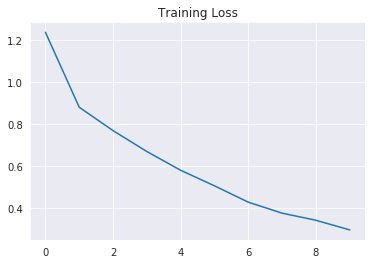

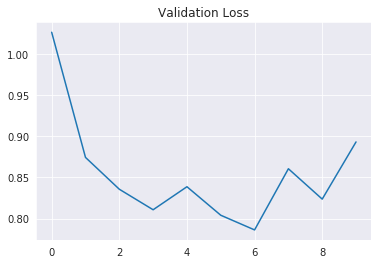

In [0]:
# Plot history
sns.set_style("darkgrid")
plt.plot(Multi_Model.history.history['loss'])
plt.title('Training Loss')

plt.show()

sns.set_style("darkgrid")
plt.plot(Multi_Model.history.history['val_loss'])
plt.title('Validation Loss')

plt.show()

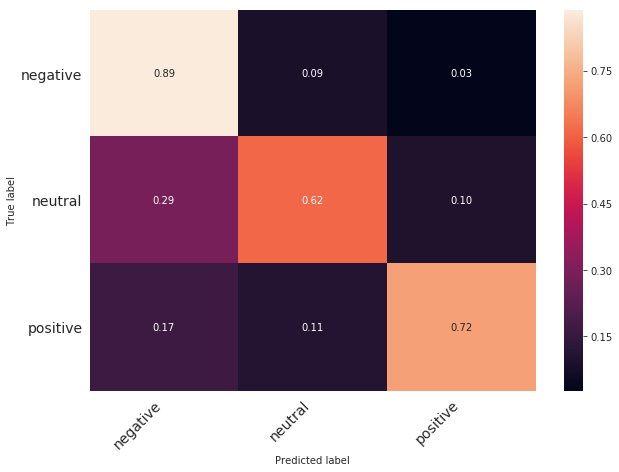

In [0]:
# Calculate outputs in test set
prob_test = np.round(Multi_Model.predict([X_test[:, 3:39], X_test[:, 0], X_test[:, 1:3]]))
prob_test = pd.DataFrame(data = prob_test, columns = ['negative', 'neutral', 'positive'])
prob_test = prob_test.idxmax(axis = 1)

y_test_label = y_test.idxmax(axis = 1)

# Calculate confusion matrix
confusion_matrix_dnn = confusion_matrix(y_true = y_test_label, 
                    y_pred = prob_test)

# Turn matrix to percentages
confusion_matrix_dnn = confusion_matrix_dnn.astype('float') / confusion_matrix_dnn.sum(axis=1)[:, np.newaxis]

# Turn to dataframe
df_cm = pd.DataFrame(
        confusion_matrix_dnn, index=['negative', 'neutral', 'positive'],
         columns=['negative', 'neutral', 'positive'], 
)

# Parameters of the image
figsize = (10,7)
fontsize=14

# Create image
fig = plt.figure(figsize=figsize)
heatmap = sns.heatmap(df_cm, annot=True, fmt='.2f')

# Make it nicer
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, 
                             ha='right', fontsize=fontsize)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45,
                             ha='right', fontsize=fontsize)

# Add labels
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Plot!
plt.show()